Adding PHoenix

In [1]:
# !pip install arize-phoenix

In [6]:
import phoenix as px
from llama_index import (
    set_global_handler,
)


In [8]:
import os

os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "http://localhost:6006"


In [10]:
import phoenix as px

session = px.launch_app()

set_global_handler("arize_phoenix")

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


### ADDING API KEY

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import io
from PIL import Image, ImageDraw
import numpy as np
import csv
import pandas as pd

from torchvision import transforms

from transformers import AutoModelForObjectDetection
import torch
import openai
import os
import fitz
from dotenv import load_dotenv
load_dotenv()


device = "cuda" if torch.cuda.is_available() else "cpu"

OPENAI_API_TOKEN = os.getenv("OPENAI_API_KEY")
openai.api_key = OPENAI_API_TOKEN


c:\Users\Lenovo\Desktop\4_testing\venv310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### converting the pdf pages into images and store in a file


In [2]:
# pdf_file = "llama2.pdf"
pdf_file = "./data/dataset_radarview.pdf"

# Split the base name and extension
output_directory_path, _ = os.path.splitext(pdf_file)

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

# Open the PDF file
pdf_document = fitz.open(pdf_file)

# Iterate through each page and convert to an image
for page_number in range(pdf_document.page_count):
    # Get the page
    page = pdf_document[page_number]

    # Convert the page to an image
    pix = page.get_pixmap()

    # Create a Pillow Image object from the pixmap
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # Save the image
    image.save(f"./{output_directory_path}/page_{page_number + 1}.png")

# Close the PDF file
pdf_document.close()


- ploting the extracted images

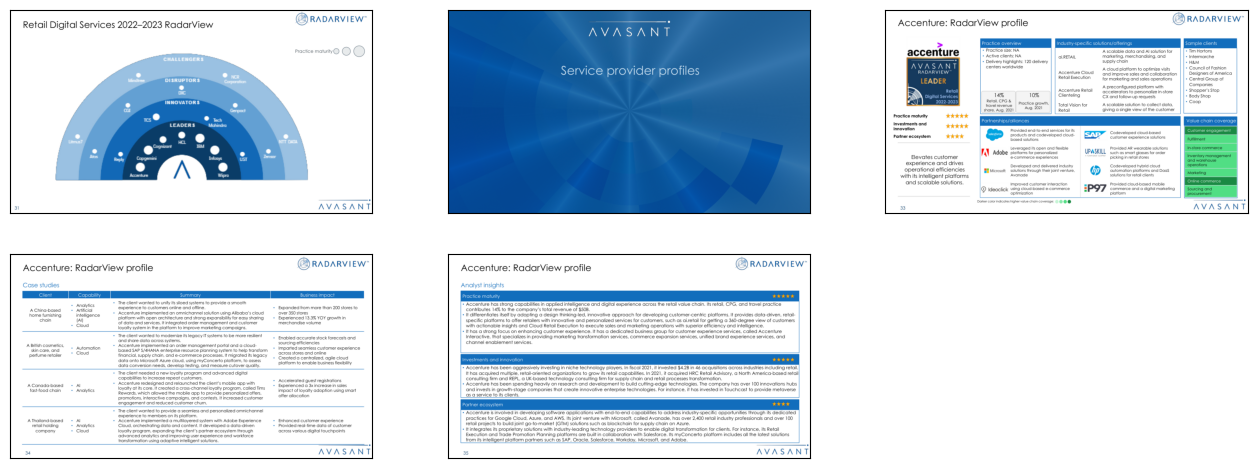

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./dataset_radarview/"):
    image_paths.append(str(os.path.join("./dataset_radarview/", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)


In [3]:
# from llama_index.multi_modal_llms.openai import OpenAIMultiModal
# from llama_index import SimpleDirectoryReader

# # put your local directore here
# documents_images_v2 = SimpleDirectoryReader("./dataset_radarview/").load_data()


In [17]:
# print(documents_images_v2[0].metadata['file_path'])
# print(documents_images_v2[0].image_path)

dataset_radarview\page_1.png


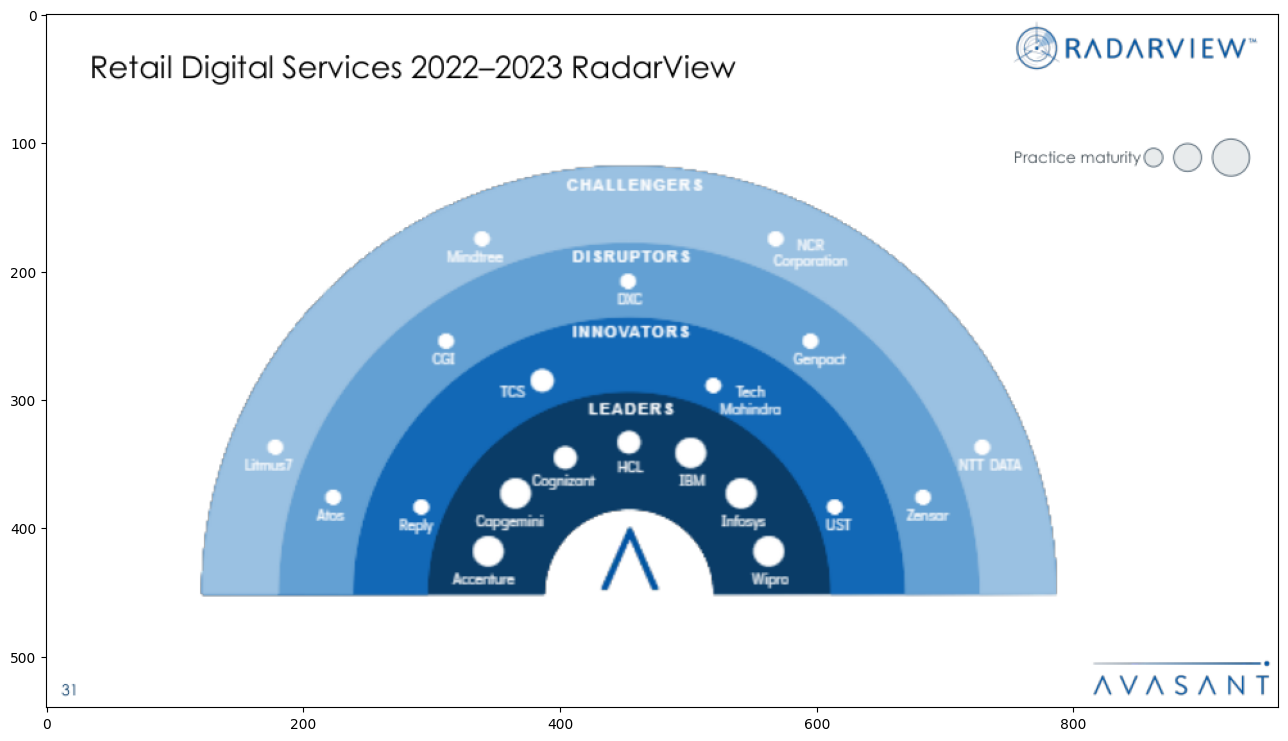

In [9]:
# image = Image.open(documents_images_v2[0].image_path).convert("RGB")

# plt.figure(figsize=(16, 9))
# plt.imshow(image)


In [12]:
# from llama_index import SimpleDirectoryReader


# documents_images_v2 = SimpleDirectoryReader("data").load_data()
# print(documents_images_v2)

[Document(id_='5af7e458-dd43-48bc-b0e9-420d8ea658ea', embedding=None, metadata={'page_label': '1', 'file_name': 'dataset_radarview.pdf', 'file_path': 'data\\dataset_radarview.pdf', 'file_type': 'application/pdf', 'file_size': 1719817, 'creation_date': '2024-01-31', 'last_modified_date': '2024-01-29', 'last_accessed_date': '2024-01-31'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='31\nRetail Digital Services 2022 –2023 RadarView\nPractice maturity\n', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), Document(id_='763c5746-603c-445d-a8f4-d487d09b0c56', embedding=None, metadata={'page_label': '2', 'file_name': 'dataset_radarview.pdf', 'file_path': 'data\\da

### GENERATING THE SUMMARY OF THE IMAGES


- step:01: convert image into base64
- step:02: make the documents/nodes form the images in base64 format
- step:03: pass the multimodel llm to generate the summary of the image
- step:04: store these summary in "images_summary"
- step:05: and also store the image document in "image_documents"

In [13]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader
import base64

def get_img_summary(img_doc, prompt):
    openai_mm_llm = OpenAIMultiModal(model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1024)
    response = openai_mm_llm.complete(
        prompt=prompt,
        image_documents=[img_doc],
    )
    return response

def get_encoded_image(path):
    with open(path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")



def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .png files extracted 
    """

    # Store base64 encoded images
    img_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    You have to generate summary only from the input images and read image in detail and depth. \
    Images may contain the ratings(in stars) so while generating summary pay extra attention in that part of image where rating is mentioned and count the stars accurately because rating must be precise and correct. \
    When you are generating summary try to divide the image in segments and then generate summary in detail and depth. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a detailed and concise summary of the image that is well optimized for retrieval.\
    """ 
    # Images may contain concentric semi-circular tracks and each track is colored with different shades of color these tracks are isolated from each other so while generating summary of each isolated track read the track in clockwise direction(from left to right) and put the text present in the particular track in one segment  which must be precise and accurate. \

    # Apply to images
    documents_images_v2 = SimpleDirectoryReader(path).load_data()
    for i,val in enumerate(documents_images_v2):
        img_base64 = get_encoded_image(val.image_path)
        # print(val.image_path)
        val.image_url = f"data:image/png;base64,{img_base64}"
        # val.metadata['file_path']=f"data:image/png;base64,{img_base64}"
        val.metadata['file_type']="data:image/png;base64,"
        image_summaries.append(get_img_summary(val,prompt))
        img_list.append(img_base64)
        documents_images_v2[i]=val
        
    return img_list, image_summaries, documents_images_v2

img_list, image_summaries, img_documents = generate_img_summaries("./dataset_radarview/")



In [15]:
for i in image_summaries:
    print(i)
# print(img_documents)
# for i in img_documents:
#     print(i)

This image is a graphical representation of the "Retail Digital Services 2022–2023 RadarView" by Avasant. The image is designed as a semi-circular radar chart with four concentric arcs representing different categories of companies in the retail digital services space: Leaders, Innovators, Disruptors, and Challengers.

Segment 1: Title and Legend
- At the top, the title "Retail Digital Services 2022–2023 RadarView" is prominently displayed.
- To the right, there is a legend indicating "Practice maturity" with three unfilled circles, suggesting a rating or status indicator.

Segment 2: Radar Chart
- The radar chart is divided into four segments, each labeled with a category of company performance.
- The innermost arc is labeled "Leaders" and includes companies such as Accenture, Capgemini, Cognizant, HCL, IBM, Infosys, TCS, and Wipro.
- The second arc is labeled "Innovators" and includes companies like Tech Mahindra and UST.
- The third arc is labeled "Disruptors" and includes DXC and N

#### take the text from the pdf so that we can get the optimal and correct answers from the pdf

In [16]:
from llama_index import VectorStoreIndex, SimpleDirectoryReader

my_text_documents = SimpleDirectoryReader("data").load_data()


In [17]:
my_text_documents

[Document(id_='56108fba-46c3-4592-ac25-1cc259445bc9', embedding=None, metadata={'page_label': '1', 'file_name': 'dataset_radarview.pdf', 'file_path': 'data\\dataset_radarview.pdf', 'file_type': 'application/pdf', 'file_size': 1719817, 'creation_date': '2024-02-01', 'last_modified_date': '2024-01-29', 'last_accessed_date': '2024-02-02'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, hash='3488f93dc513262aeeedf2aea201d48c8ba39d3555454a4590f8bee53d578ac9', text='31\nRetail Digital Services 2022 –2023 RadarView\nPractice maturity\n', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'),
 Document(id_='7f46ea5b-c190-4037-8245-eaf8e6016760', embedding=None, metadata={'page

### MAKE THE MULTIMODEL VECTOR STORE : 

- make multimodel vector store
- this multimodel vector store : stores the images documents

In [18]:
import qdrant_client


from llama_index import (
    ServiceContext,
    SimpleDirectoryReader,
    Document
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex, StorageContext
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

### attaching the summary with images

In [19]:
import uuid
from llama_index import Document
from llama_index import VectorStoreIndex
from llama_index.llms import OpenAI
# Create the MultiModal index
# documents = SimpleDirectoryReader("./data_wiki/").load_data()

# def get_encoded_image(path):
#     with open(path, "rb") as image_file:
#         return base64.b64encode(image_file.read()).decode("utf-8")


def add_documents(doc_summaries, doc_contents, img_documents, path):
    doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
    
    for i,val in enumerate(img_documents):
        # img_base64 = get_encoded_image(val.image_url)
        # val.image_url = f"data:image/jpeg;base64,{img_base64}"
        # val.metadata['file_path']=f"data:image/png;base64,{img_base64}"
        val.metadata['file_type']="data:image/png;base64,"
        val.metadata['id_key']=doc_ids[i]
        val.metadata['index']=i
        img_documents[i]=val
        
    summary_docs = [
        Document(text=str(s), metadata={'id_key': doc_ids[i], 'index':i})
        for i, s in enumerate(doc_summaries)
    ]
    return summary_docs, img_documents

documents, new_doc_img = add_documents(image_summaries, img_list, img_documents, "./Radarview_2/")



[ImageDocument(id_='4ae241c3-6b07-4680-b096-5566a4f3e761', embedding=None, metadata={'file_path': 'dataset_radarview\\page_1.png', 'file_name': 'page_1.png', 'file_type': 'data:image/png;base64,', 'file_size': 92704, 'creation_date': '2024-02-02', 'last_modified_date': '2024-02-02', 'last_accessed_date': '2024-02-02', 'id_key': 'a040bb01-0285-4a55-8331-f1cce0687332', 'index': 0}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, hash='91d234f162d4c5ef3c424d83c244ac1dfcc8a426a6703544bc29c35bc1d99e31', text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='dataset_radarview\\page_1.png', image_url='', text_embedding=None),
 ImageDocument(id_=
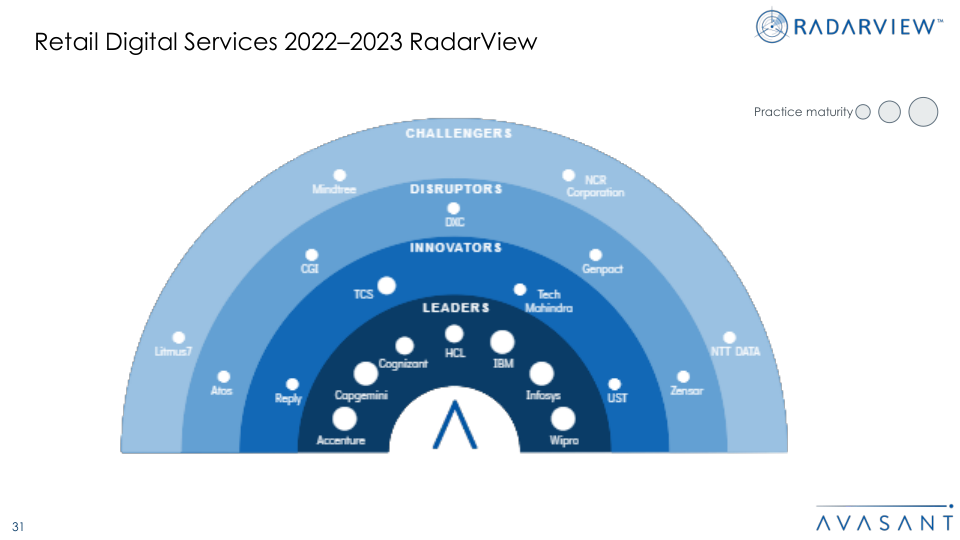
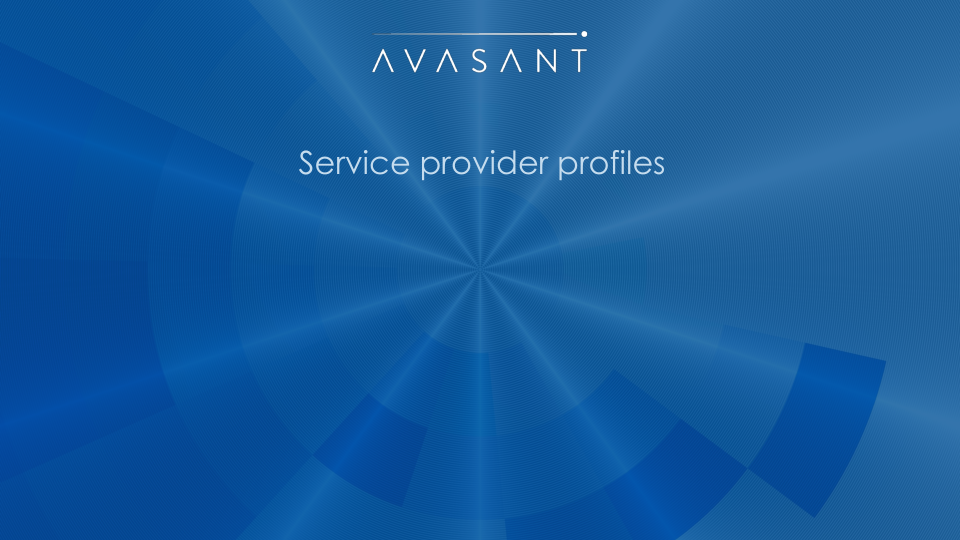
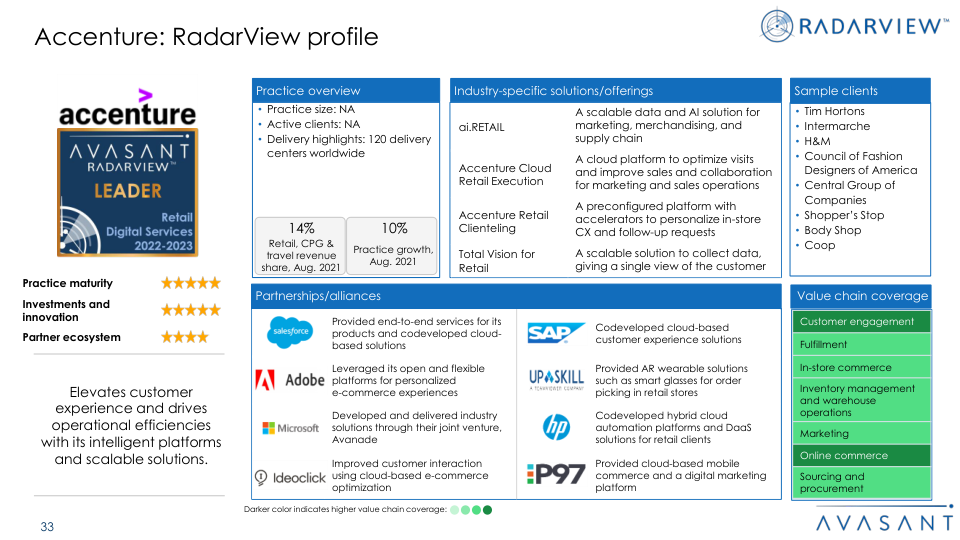
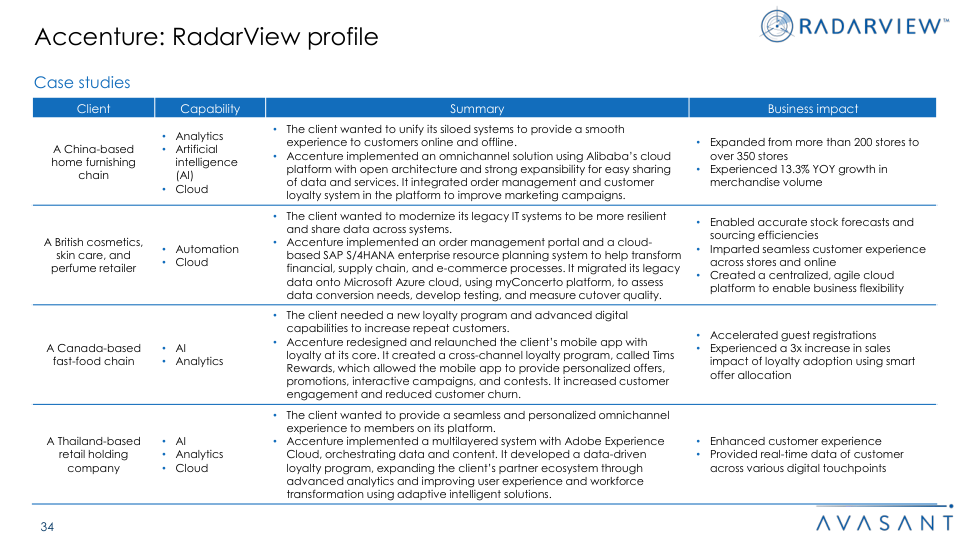
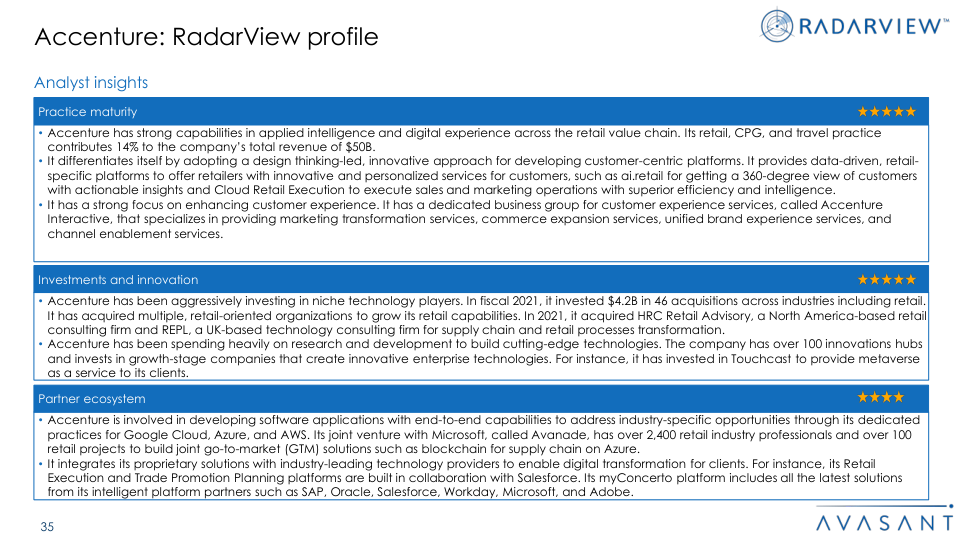

In [20]:
new_doc_img

In [21]:
documents

[Document(id_='b73bff73-9ccb-49df-b196-0917d5806d0c', embedding=None, metadata={'id_key': 'a040bb01-0285-4a55-8331-f1cce0687332', 'index': 0}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, hash='783f70ea726fbb7762623e132ef55fe6789e4d5e037b157b0ad8e51c19a3b49b', text='This image is a graphical representation of the "Retail Digital Services 2022–2023 RadarView" by Avasant. The image is designed as a semi-circular radar chart with four concentric arcs representing different categories of companies in the retail digital services space: Leaders, Innovators, Disruptors, and Challengers.\n\nSegment 1: Title and Legend\n- At the top, the title "Retail Digital Services 2022–2023 RadarView" is prominently displayed.\n- To the right, there is a legend indicating "Practice maturity" with three unfilled circles, suggesting a rating or status indicator.\n\nSegment 2: Radar Chart\n- The radar chart is divided into four segments, each labeled with a category of comp

In [22]:
print(new_doc_img[2].metadata['index'])

2


#### creating the index from the multimodel vector store

[ImageDocument(id_='4ae241c3-6b07-4680-b096-5566a4f3e761', embedding=None, metadata={'file_path': 'dataset_radarview\\page_1.png', 'file_name': 'page_1.png', 'file_type': 'data:image/png;base64,', 'file_size': 92704, 'creation_date': '2024-02-02', 'last_modified_date': '2024-02-02', 'last_accessed_date': '2024-02-02', 'id_key': 'a040bb01-0285-4a55-8331-f1cce0687332', 'index': 0}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, hash='91d234f162d4c5ef3c424d83c244ac1dfcc8a426a6703544bc29c35bc1d99e31', text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='dataset_radarview\\page_1.png', image_url='', text_embedding=None),
 ImageDocument(id_=
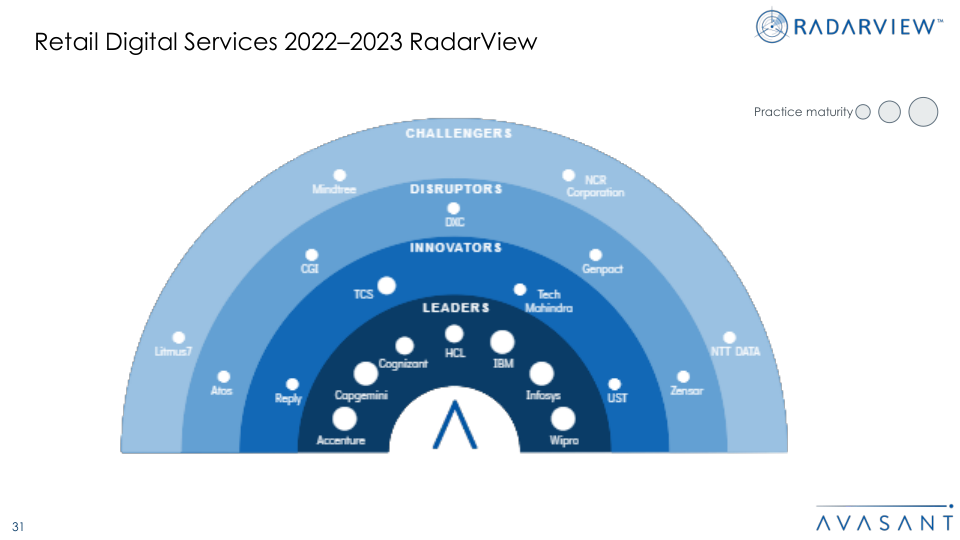
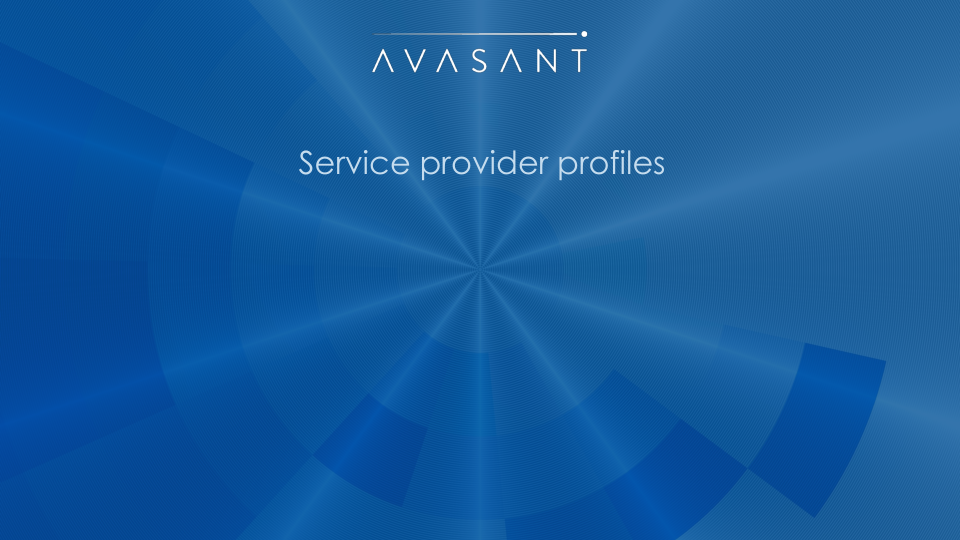
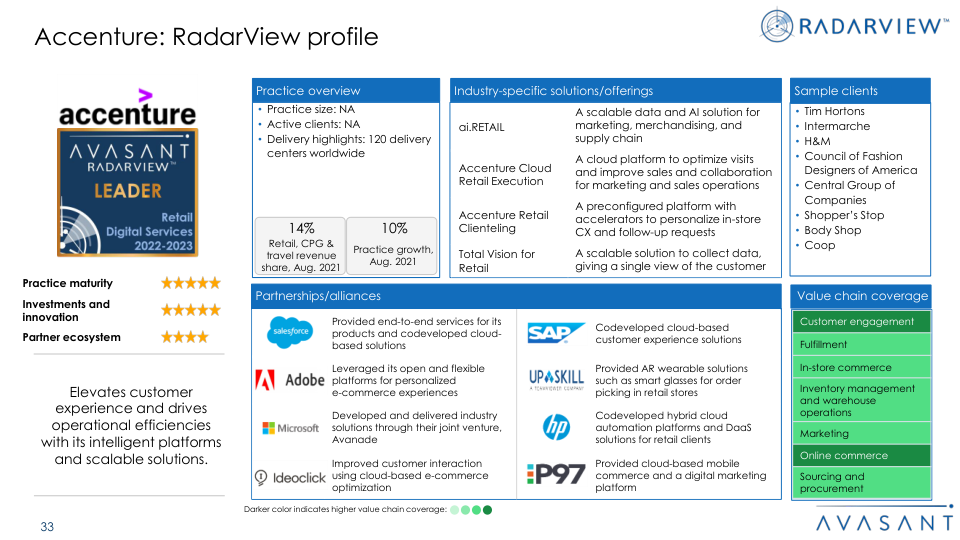
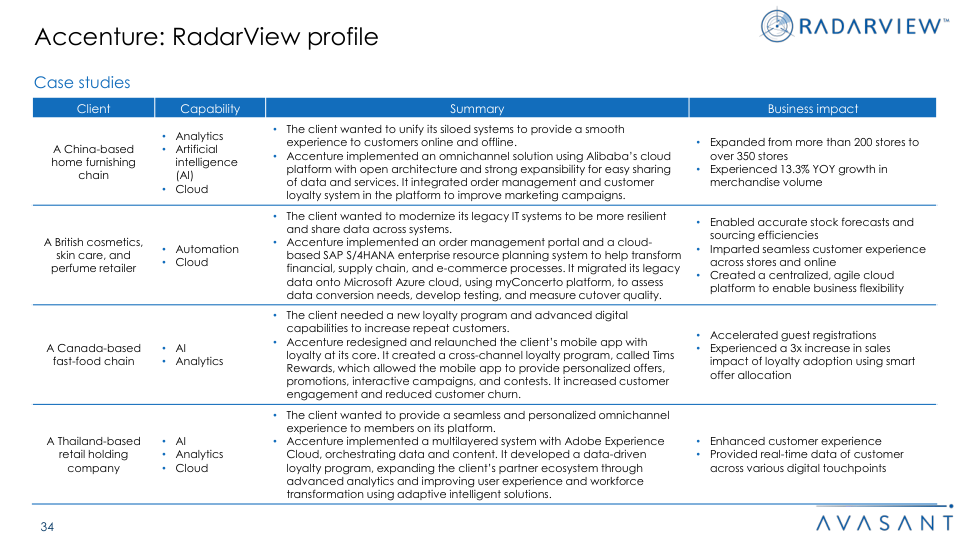
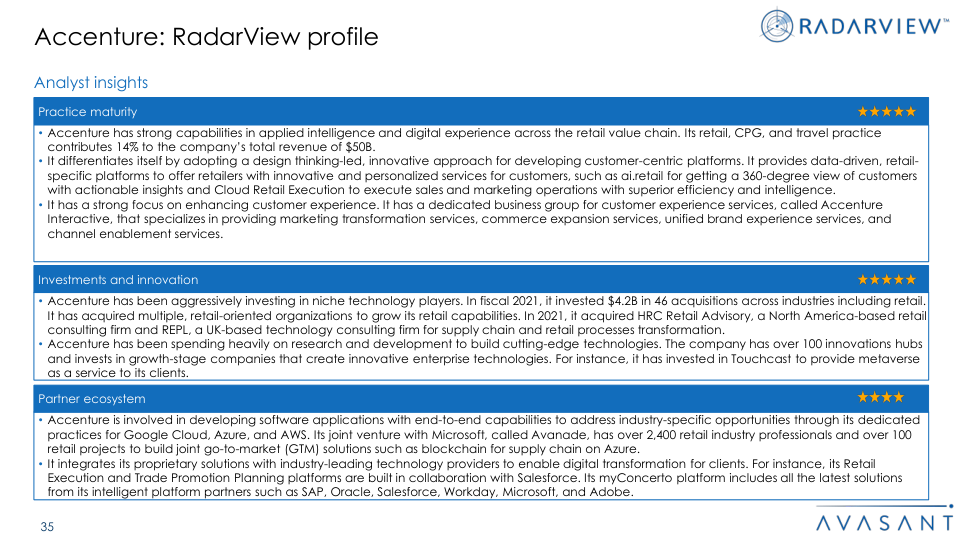

In [23]:
llm = OpenAI(model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN)
service_context = ServiceContext.from_defaults(llm=llm)


mixed_doc = []
for i in new_doc_img:
    mixed_doc.append(i)

for i,val in enumerate(my_text_documents):
    val.metadata["id_key"]="thisisidkey_"+str(i)
    mixed_doc.append(val)

index_img = MultiModalVectorStoreIndex.from_documents(
    # documents=documents,
    # documents,
    mixed_doc,
    storage_context=storage_context,
    service_context=service_context
)
mixed_doc


In [24]:
# print(documents)
for i in documents:
    print(i.metadata['id_key'])
    # print(i.metadata['index'])


a040bb01-0285-4a55-8331-f1cce0687332
f883f69f-dcac-4b7c-95cc-4815a69a8eda
1fd82df2-a8ef-4f01-b894-ab4af9b71e44
a5d4d1a7-4d53-4516-8bcd-05b0db3aa509
6810b47f-67f9-4045-9611-a96f8bc5b76f


In [25]:
# print(new_doc_img)
for i in new_doc_img:
    print(i.metadata['id_key'])

a040bb01-0285-4a55-8331-f1cce0687332
f883f69f-dcac-4b7c-95cc-4815a69a8eda
1fd82df2-a8ef-4f01-b894-ab4af9b71e44
a5d4d1a7-4d53-4516-8bcd-05b0db3aa509
6810b47f-67f9-4045-9611-a96f8bc5b76f


In [26]:
for i in mixed_doc:
    print(i.metadata['id_key'])

a040bb01-0285-4a55-8331-f1cce0687332
f883f69f-dcac-4b7c-95cc-4815a69a8eda
1fd82df2-a8ef-4f01-b894-ab4af9b71e44
a5d4d1a7-4d53-4516-8bcd-05b0db3aa509
6810b47f-67f9-4045-9611-a96f8bc5b76f
thisisidkey_0
thisisidkey_1
thisisidkey_2
thisisidkey_3
thisisidkey_4


#### make the retriever : which is retrieving the relevant images from the MM_vector_store

In [27]:

def get_retrieve_result(query):
    prompt = (
    "Give a detailed and most accurate results that is well optimized for retrieval. \n\n"
    f"user question is : {query}\n"
    "Answer is : "
    ) 

    retriever = index_img.as_retriever(similarity_top_k=6, image_similarity_top_k=6)
    retrieval_results = retriever.retrieve(prompt)
    return retrieval_results




- ploting the base64 encoded image : which is retrieved from the retriever

In [28]:
from IPython.display import HTML, display
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/png;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))



In [29]:
# print(len(retrieval_results))
# res = get_retrieve_result("In accenture radarview profile what are the partnerships/alliances of accenture?")

In [30]:
# from llama_index.response.notebook_utils import display_source_node
# from llama_index.schema import ImageNode

# retrieved_image = []
# for res_node in res:
#     if isinstance(res_node.node, ImageNode):
#         plt_img_base64(res_node.node.image_url[22:])
#     else:
#         print(res_node.node.text, end="\n\n\n")


In [31]:
# x = get_retrieve_result("what are the comapnies comes under partnerships/alliances of accenture?")
# # plt_img_base64(new_doc_img[x[0].metadata['index']].image_url[22:])
# # print(x[0].node.text)
# plt_img_base64(x[0].node.image_url[22:])

##### stored the retrieved results in seperated columns of dictionary : 

- in 'text' : we storing the raw text received from retriever + attached summary of the images retireved 
- in 'images' : we storing the images retrieved

In [32]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

# def resize_base64_image(base64_string, size=(128, 128)):
#     """
#     Resize an image encoded as a Base64 string
#     """
#     # Decode the Base64 string
#     img_data = base64.b64decode(base64_string)
#     img = Image.open(io.BytesIO(img_data))

#     # Resize the image
#     resized_img = img.resize(size, Image.LANCZOS)

#     # Save the resized image to a bytes buffer
#     buffered = io.BytesIO()
#     resized_img.save(buffered, format=img.format)

#     # Encode the resized image to Base64
#     return base64.b64encode(buffered.getvalue()).decode("utf-8")



def get_retrive_text_image_both(retrieval_results):

    retrive_msg = {}
    text=[]
    img = []
    # for i in retrieval_results:
    #     # print(i.metadata["id_key"])
    #     idx = i.metadata['index']
    #     # print(i.score)
    #     # plt_img_base64(i.node.image_url[23:])
    #     # print(documents[idx].text)
    #     text.append(documents[idx].text)
    #     img.append(i.node.image_url)
    
    
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            # plt_img_base64(res_node.node.image_url[22:])
            img.append(res_node.node.image_url)
            idx = res_node.node.metadata['index']
            text.append(documents[idx].text)
        else:
            # print(res_node.node.text, end="\n\n\n")
            text.append(res_node.node.text)
        
    retrive_msg['texts']=text
    retrive_msg['images']=img
    return retrive_msg


# print(retrieval_results)
# retrive_msg = get_retrive_text_image_both(get_retrieve_result(query))
# print(retrive_msg)




- GIVE THE TEXT AND IMAGES RETIVED FROM THE RETRIEVER TO THE MM_LLM AND GENERATE THE FINALY ANSWER OF THE QUERY

In [46]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


# def looks_like_base64(sb):
#     """Check if the string looks like base64"""
#     return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


# def is_image_data(b64data):
#     """
#     Check if the base64 data is an image by looking at the start of the data
#     """
#     image_signatures = {
#         b"\xFF\xD8\xFF": "jpg",
#         b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
#         b"\x47\x49\x46\x38": "gif",
#         b"\x52\x49\x46\x46": "webp",
#     }
#     try:
#         header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
#         for sig, format in image_signatures.items():
#             if header.startswith(sig):
#                 return True
#         return False
#     except Exception:
#         return False


# def resize_base64_image(base64_string, size=(128, 128)):
#     """
#     Resize an image encoded as a Base64 string
#     """
#     # Decode the Base64 string
#     img_data = base64.b64decode(base64_string)
#     img = Image.open(io.BytesIO(img_data))

#     # Resize the image
#     resized_img = img.resize(size, Image.LANCZOS)

#     # Save the resized image to a bytes buffer
#     buffered = io.BytesIO()
#     resized_img.save(buffered, format=img.format)

#     # Encode the resized image to Base64
#     return base64.b64encode(buffered.getvalue()).decode("utf-8")


# def split_image_text_types(docs):
#     """
#     Split base64-encoded images and texts
#     """
#     b64_images = []
#     texts = []
#     for doc in docs:
#         # Check if the document is of type Document and extract page_content if so
#         if isinstance(doc, Document):
#             doc = doc.page_content
#         if looks_like_base64(doc) and is_image_data(doc):
#             doc = resize_base64_image(doc, size=(1300, 600))
#             b64_images.append(doc)
#         else:
#             texts.append(doc)
#     return {"images": b64_images, "texts": texts}


def img_prompt_func(question, retrive_msg):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(retrive_msg["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if retrive_msg["images"]:
        for image in retrive_msg["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "You also have to analyse provided images in detail before giving answer. \n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {question}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def getAns(question, retrive_msg):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    ans = model.invoke(
        img_prompt_func(question, retrive_msg)
    )

    return ans


# Create RAG chain
def get_final_ans(query):
    retrive_ans = get_retrieve_result(query)
    # print(retrive_ans[0].node.image_url[22:])
    retrive_msg = get_retrive_text_image_both(retrive_ans)
    res = getAns(query, retrive_msg)
    return res

- get results 

In [47]:
res = get_final_ans("is there any logo of SAP company in partnerships/allances section of accenture radarview profile?")
print(res.content)

In [38]:
res = get_final_ans("do you know the HP company logo? if yes then describe it")
print(res)

content="I'm sorry, but I cannot provide information on the HP company logo as it is not related to the provided images or text. However, if you have any questions regarding the investment-related information provided in the images or text about Accenture's profile in the RadarView by Avasant, I would be happy to help with that."


In [34]:
res = get_final_ans("what are accenture partnership/alliance companies? answer in tabular format")
print(res.content)

| Partner Company | Description of Services |
|-----------------|-------------------------|
| Salesforce      | Provided end-to-end services for its products and co-developed cloud-based solutions. |
| Adobe          | Leveraged its open and flexible platforms for personalized e-commerce experiences. |
| Microsoft      | Developed and delivered industry solutions through their joint venture, Avanade. |
| Ideoclick      | Improved customer interaction using cloud-based e-commerce optimization. |


In [34]:
res = get_final_ans("what is the rating of practice maturity of accenture : radarview profile")
print(res.content)

Based on the information provided in the slides, Accenture's practice maturity in the RadarView profile is rated with five stars. This high rating indicates that Accenture has strong capabilities in applied intelligence and digital experience across the retail value chain. The company's focus on customer-centric platforms, data-driven retail-specific platforms, and enhancing customer experience through various services contributes to this high level of practice maturity.

As a financial analyst providing investment advice, the five-star rating in practice maturity, along with Accenture's aggressive investment in technology and acquisitions, suggests that the company is well-positioned in the market and is actively expanding its capabilities and services. The company's dedication to innovation and its strong partner ecosystem further support its competitive position in the industry.

Investors looking for a company with a robust growth strategy in the digital and retail services space m

In [35]:
res = get_final_ans("what is the rating of Partner Ecosystem of accenture : radarview profile")
print(res.content)

The rating of the Partner Ecosystem for Accenture in the RadarView profile is four stars. This information is found in the second image provided, where the Partner Ecosystem section is rated with four stars, indicating a strong but not perfect rating in this area.


In [36]:
res = get_final_ans("what are the companies which falls under leaders, innovators, disruptors, challengers in retail digital services 2022-2023? answer in tabular format")
print(res.content)

Based on the provided images, here is the tabular format listing the companies under each category in the Retail Digital Services 2022-2023 RadarView:

| Category    | Companies                                      |
|-------------|------------------------------------------------|
| Leaders     | Accenture, Capgemini, Cognizant, HCL, IBM, Infosys, TCS, Wipro |
| Innovators  | CGI, DXC, Genpact, Tech Mahindra               |
| Disruptors  | NCR Corporation                                |
| Challengers | Atos, LTI (Larsen & Toubro Infotech), Mindtree, Reply, UST |

This categorization can help investors understand the competitive landscape and identify companies that are leading, innovating, disrupting, or challenging the retail digital services market. Investors may consider these categories when making decisions about where to allocate their investment resources, keeping in mind that leaders might offer stability and proven track records, while innovators and disruptors could present 

In [37]:
res = get_final_ans("can you please provide the table of case study of accenture RadarView Profile? in tabular format")
print(res.content)

Certainly! Here is the table of case studies from the Accenture RadarView Profile:

| Client                          | Capability                | Summary                                                                                                                                                                                                 | Business Impact                                                                                   |
|---------------------------------|---------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| A China-based home furnishing chain | Analytics, AI, Cloud      | Implemented an omnichannel solution using Alibaba's cloud platform to unify siloed systems, integrate order managemen

In [38]:
res = get_final_ans("what is the difference b/w accenture case studies and accenture analyst insights from the accenture Radarview Profile? in points")
print(res.content)

The difference between Accenture's case studies and analyst insights from the Accenture RadarView Profile can be summarized in the following points:

1. **Purpose**:
   - **Case Studies**: Provide specific examples of how Accenture's services have been applied to solve real-world problems for clients, demonstrating the practical impact of their solutions.
   - **Analyst Insights**: Offer a high-level overview of Accenture's capabilities, investment strategies, and the breadth of their partner ecosystem, providing a general assessment of the company's position in the market.

2. **Content**:
   - **Case Studies**: Detail the capabilities used (e.g., AI, Analytics, Cloud), the client's objectives, the solutions implemented by Accenture, and the tangible business impacts such as increased sales or improved customer experience.
   - **Analyst Insights**: Discuss Accenture's overall practice maturity, areas of investment and innovation, and the strength of their partnerships with other tech

In [105]:
# from llama_index.llms import OpenAI
# from llama_index import VectorStoreIndex, ServiceContext

# service_context = ServiceContext.from_defaults(llm=OpenAI(model="gpt-4", api_key=OPENAI_API_TOKEN, temperature=0))

# index = VectorStoreIndex.from_documents(documents, service_context=service_context)


In [21]:
# from llama_index.prompts import PromptTemplate
# # from llama_index.llms import OpenAI

# # llm = OpenAI(model="gpt-4", api_key=OPENAI_API_TOKEN, max_new_tokens=1024, temperature=0)

# question = "what are accenture partnership/alliance companies?"

# prompt = (
#     "You are financial analyst tasking with providing investment advice.\n"
#     "You will be given a mixed of summaries of text, tables, and image(s) usually of charts or graphs. \n"
#     "Use this information to provide investment advice related to the user question. \n"
#     f"User-provided question: {question}\n\n"
#     "You answer: "
#     # "Text and / or tables:\n"
#     # f"{formatted_texts}"
#     )
 
# qa_prompt_tmpl = PromptTemplate(prompt, question=question)




In [26]:
# from llama_index import get_response_synthesizer


# retriever = index.as_retriever(similarity_top_k=1)
# # synth = get_response_synthesizer(
# #     text_qa_template=qa_prompt_tmpl
# # )
# retrieval_results = retriever.retrieve(question)

In [27]:
# for i in retrieval_results:
#     print(i.metadata['id_key'])

b698d900-ee01-462d-8d0b-73c1fb066486
